# Exploratory Data Analysis

## Importing Libraries

In [1]:
import os
import re
import string
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def check_nltk_resource(resource):
    try:
        nltk.data.find(resource)
    except LookupError:
        nltk.download(resource.split("/")[-1], quiet=True)

check_nltk_resource("tokenizers/punkt")
check_nltk_resource("corpora/stopwords")
check_nltk_resource("sentiment/vader_lexicon")
sia = SentimentIntensityAnalyzer()

#### Additional Libraries

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def extract_features(text):
    """Extract basic text features for EDA analysis."""
    if not isinstance(text, str):
        text = str(text)

    features = {}

    # Basic counts
    features['char_count'] = len(text)
    features['word_count'] = len(text.split())
    features['sentence_count'] = text.count('.') + text.count('!') + text.count('?')

    # Average word length
    words = text.split()
    features['avg_word_length'] = sum(len(w) for w in words) / len(words) if words else 0

    # Token placeholder counts (for cleaned text)
    features['url_count'] = text.count('[URL]')
    features['email_count'] = text.count('[EMAIL]')

    return features

# Inspecting Datasets

In [4]:
# Define path to raw data files
# Detect environment and set appropriate path

import sys

# Check if running on Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Mount Google Drive if on Colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Update this path to match where your files are in Google Drive
    # Example: '/content/drive/MyDrive/multi-class-phishing/raw_files/'
    RAW_DATA_PATH = '/content/drive/MyDrive/multi-class-phishing/raw_files/'

    print(f"🌐 Running on Google Colab")
    print(f"📁 Data path: {RAW_DATA_PATH}")
else:
    # Local environment - use relative path from notebook location
    RAW_DATA_PATH = '../raw_files/'
    print(f"💻 Running locally")
    print(f"📁 Data path: {RAW_DATA_PATH}")

# Verify the path exists
if not os.path.exists(RAW_DATA_PATH):
    print(f"\n⚠️ WARNING: Path '{RAW_DATA_PATH}' does not exist!")
    print("Please update RAW_DATA_PATH to point to your data files.")
    if IN_COLAB:
        print("\nFor Colab, make sure to:")
        print("1. Upload your raw_files folder to Google Drive")
        print("2. Update RAW_DATA_PATH above to match your Drive path")
else:
    print(f"✅ Path exists! Files found: {os.listdir(RAW_DATA_PATH)}")

data_files = {
    'Ling-Spam': 'Ling.csv',
    'Nazario': 'Nazario.csv',
    'SpamAssassin': 'SpamAssasin.csv',
    'CEAS_08': 'CEAS_08.csv',
    'Enron': 'Enron.csv'
}

datasets = {}

for name, filename in data_files.items():
    filepath = os.path.join(RAW_DATA_PATH, filename)
    print(f"\n{'='*80}")
    print(f"Loading: {name}")
    print(f"{'='*80}")

    try:
        df = pd.read_csv(
            filepath,
            encoding='utf-8',
            on_bad_lines='warn',
            engine='python'
        )

    except Exception as e:
        df = pd.read_csv(
            filepath,
            encoding='latin-1',
            on_bad_lines='warn',
            engine='python'
        )

    unnamed_cols = [col for col in df.columns if 'Unnamed' in str(col)]
    if unnamed_cols:
        df = df.drop(columns=unnamed_cols)

    df = df.dropna(how='all')

    datasets[name] = df

    print(f"\nShape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nData types:\n{df.dtypes}")
    print(f"\nMissing values:\n{df.isnull().sum()}")
    print(f"\nSample rows:")
    print(df.head(2))

    label_cols = [col for col in df.columns if 'label' in col.lower()]
    if label_cols:
        print(f"\nLabel distribution:\n{df[label_cols[0]].value_counts()}")
        print(f"Label percentages:\n{df[label_cols[0]].value_counts(normalize=True) * 100}")

print(f"\n{'='*80}")
print("All datasets loaded successfully!")
print(f"{'='*80}")

Mounted at /content/drive
🌐 Running on Google Colab
📁 Data path: /content/drive/MyDrive/multi-class-phishing/raw_files/
✅ Path exists! Files found: ['Ling.csv', 'Nazario.csv', 'SpamAssasin.csv', 'Enron.csv', 'CEAS_08.csv']

Loading: Ling-Spam

Shape: (2859, 3)
Columns: ['subject', 'body', 'label']

Data types:
subject    object
body       object
label       int64
dtype: object

Missing values:
subject    62
body        0
label       0
dtype: int64

Sample rows:
                                   subject  \
0  job posting - apple-iss research center   
1                                      NaN   

                                                body  label  
0  content - length : 3386 apple-iss research cen...      0  
1  lang classification grimes , joseph e . and ba...      0  

Label distribution:
label
0    2401
1     458
Name: count, dtype: int64
Label percentages:
label
0    83.980413
1    16.019587
Name: proportion, dtype: float64

Loading: Nazario

Shape: (1563, 7)
Columns: ['s

#### Standardizing Columns


In [5]:
def standardize_dataset(df, dataset_name):

    df_std = df.copy()

    initial_rows = len(df_std)

    df_std['source_dataset'] = dataset_name

    if 'subject' in df_std.columns and 'body' in df_std.columns:
        df_std['subject'] = df_std['subject'].fillna('').astype(str)
        df_std['body'] = df_std['body'].fillna('').astype(str)
        df_std['text'] = df_std['subject'] + ' ' + df_std['body']
    elif 'body' in df_std.columns:
        df_std['text'] = df_std['body'].fillna('').astype(str)
    elif 'subject' in df_std.columns:
        df_std['text'] = df_std['subject'].fillna('').astype(str)
    else:
        text_cols = [col for col in df_std.columns if col not in ['label', 'sender', 'receiver', 'date', 'urls']]
        if text_cols:
            df_std['text'] = df_std[text_cols[0]].fillna('').astype(str)

    if 'label' in df_std.columns:
        original_labels = df_std['label'].copy()

        df_std['label'] = pd.to_numeric(df_std['label'], errors='coerce')

        invalid_labels = df_std['label'].isna().sum()
        if invalid_labels > 0:
            print(f"There are {invalid_labels} rows with invalid/non-numeric labels to be removed.")

        df_std = df_std.dropna(subset=['label'])

        df_std['label'] = df_std['label'].apply(lambda x: 1 if x > 0 else 0)

        df_std['label'] = df_std['label'].astype(int)
    else:
        # If no label column exists, assume all are phishing
        df_std['label'] = 1

    essential_cols = ['text', 'label', 'source_dataset']

    optional_cols = ['sender', 'receiver', 'date', 'urls']
    for col in optional_cols:
        if col in df_std.columns:
            essential_cols.append(col)

    df_std = df_std[essential_cols]

    # Remove rows with empty or invalid text
    df_std['text'] = df_std['text'].astype(str)
    df_std = df_std[df_std['text'].str.strip() != '']
    df_std = df_std[df_std['text'] != 'nan']

    # Keep only rows with at least 10 characters
    df_std = df_std[df_std['text'].str.len() >= 10]

    df_std = df_std.reset_index(drop=True)

    rows_removed = initial_rows - len(df_std)
    if rows_removed > 0:
        print(f"Removed {rows_removed} malformed/empty rows during standardization.")

    return df_std

# Standardize all datasets
standardized_datasets = {}

for name, df in datasets.items():
    print(f"Processing: {name}")
    df_std = standardize_dataset(df, name)
    standardized_datasets[name] = df_std
    print(f"  - Shape after standardization: {df_std.shape}")
    print(f"  - Columns: {list(df_std.columns)}")
    print(f"  - Label distribution: {df_std['label'].value_counts().to_dict()}\n")

Processing: Ling-Spam
  - Shape after standardization: (2859, 3)
  - Columns: ['text', 'label', 'source_dataset']
  - Label distribution: {0: 2401, 1: 458}

Processing: Nazario
  - Shape after standardization: (1563, 7)
  - Columns: ['text', 'label', 'source_dataset', 'sender', 'receiver', 'date', 'urls']
  - Label distribution: {1: 1563}

Processing: SpamAssassin
There are 2058 rows with invalid/non-numeric labels to be removed.
Removed 2058 malformed/empty rows during standardization.
  - Shape after standardization: (5805, 7)
  - Columns: ['text', 'label', 'source_dataset', 'sender', 'receiver', 'date', 'urls']
  - Label distribution: {0: 4089, 1: 1716}

Processing: CEAS_08
  - Shape after standardization: (39153, 7)
  - Columns: ['text', 'label', 'source_dataset', 'sender', 'receiver', 'date', 'urls']
  - Label distribution: {1: 21842, 0: 17311}

Processing: Enron
There are 1512 rows with invalid/non-numeric labels to be removed.
Removed 1515 malformed/empty rows during standardiza

#### Cleaning and Preprocessing Data



In [6]:
import base64
import quopri
from bs4 import BeautifulSoup
import hashlib

def clean_text(text):
    """
    Clean email text while preserving content for BERT processing.
    Minimal preprocessing as recommended for transformer models.
    """
    if not isinstance(text, str) or text.strip() == '':
        return ''

    # Decode encoded content (base64, quoted-printable)
    try:
        if 'base64' in text.lower():
            try:
                text = base64.b64decode(text).decode('utf-8', errors='ignore')
            except:
                pass

        if '=' in text and any(c in text for c in ['=20', '=3D', '=\n']):
            try:
                text = quopri.decodestring(text.encode()).decode('utf-8', errors='ignore')
            except:
                pass
    except:
        pass

    # Strip HTML markup
    try:
        soup = BeautifulSoup(text, 'html.parser')
        for script in soup(['script', 'style', 'meta', 'head']):
            script.decompose()
        text = soup.get_text(separator=' ')
    except:
        pass

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)

    # Replace URLs with generic token
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '[URL]', text)
    text = re.sub(r'www\.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '[URL]', text)

    # Replace email addresses with generic token
    text = re.sub(r'[\w\.-]+@[\w\.-]+\.\w+', '[EMAIL]', text)

    # Replace year tokens (1990-2030) with generic token to avoid dataset-specific artifacts
    text = re.sub(r'\b(19|20)\d{2}\b', '[YEAR]', text)

    # Remove common email header/forwarding artifacts (dataset-specific noise)
    # Enron artifacts: "wrote", "ect", "hou", "cc:", "subject:", "from:", "to:", "sent:"
    # These appear in forwarded email chains and are not indicative of phishing
    header_patterns = [
        r'\b[A-Za-z]+\s+wrote\s*:', # "John wrote:", "Smith wrote:"
        r'\bwrote\s*:',
        r'\b(ect|hou)\b',  # Enron internal codes
        r'^\s*(from|to|cc|bcc|sent|date|subject)\s*:', # Email headers at line start
        r'-{2,}\s*(original message|forwarded|begin forward)', # Forwarded message markers
        r'_{2,}',  # Underscores used as separators
    ]
    for pattern in header_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE | re.MULTILINE)

    # Remove dataset-specific identifiers (expanded list based on TF-IDF/SHAP analysis)
    dataset_artifacts = [
        # Dataset names
        r'\benron\b',
        r'\bopensuse\b',
        r'\bpython[- ]?dev\b',
        # Enron-specific names and locations
        r'\bvince\b',
        r'\bkaminski\b',
        r'\blouise\b',
        r'\btony\b',
        r'\bdave\b',
        r'\bhouston\b',
        r'\bhpl\b',  # Houston Pipe Line (Enron subsidiary)
        # Enron schedule artifacts
        r'\bhourahead\b',
        r'\bvariances\s+detected\b',
        r'\bstart\s+date\b',
        r'\bancillary\s+schedules?\b',
        # Area codes that are Enron-specific
        r'\b713\b',  # Houston area code (appears almost exclusively in Enron)
        # CNN newsletter artifacts (CEAS_08 spam)
        r'\bcnn\b',
        r'\bcnn\s+com\b',
        r'\bcnn\s+alerts?\b',
        r'\bcustom\s+alert\b',
        r'\bdaily\s+10\b',
        r'\bcable\s+news\s+network\b',
        r'\blp\s+lllp\b',
        r'\blllp\b',
        r'\btime\s+warner\b',
        r'\batlanta\b',
        r'\bgeorgia\b',
        r'\bedt\b',  # Eastern Daylight Time (CNN timestamps)
        r'\balter\s+alert\b',
        r'\bcriteria\s+frequency\b',
    ]
    for pattern in dataset_artifacts:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    # Clean up text
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = ' '.join(text.split())

    return text.strip()

def hash_text(text):
    """Generate MD5 hash for text deduplication."""
    return hashlib.md5(text.encode('utf-8')).hexdigest()

# Apply cleaning to all datasets
for name, df in standardized_datasets.items():
    print(f"Cleaning: {name}")

    print(f"  Example before cleaning (first 200 chars):")
    print(f"  {df['text'].iloc[0][:200]}...")

    # Apply cleaning
    df['text_cleaned'] = df['text'].apply(clean_text)

    print(f"\n  Example after cleaning (first 200 chars):")
    print(f"  {df['text_cleaned'].iloc[0][:200]}...")

    avg_len_before = df['text'].str.len().mean()
    avg_len_after = df['text_cleaned'].str.len().mean()
    print(f"\n  Average length before: {avg_len_before:.0f} characters")
    print(f"  Average length after: {avg_len_after:.0f} characters")
    print(f"  Reduction: {((avg_len_before - avg_len_after) / avg_len_before * 100):.1f}%\n")
    print(f"{'='*80}\n")

Cleaning: Ling-Spam
  Example before cleaning (first 200 chars):
  job posting - apple-iss research center content - length : 3386 apple-iss research center a us $ 10 million joint venture between apple computer inc . and the institute of systems science of the natio...

  Example after cleaning (first 200 chars):
  job posting - apple-iss research center content - length : 3386 apple-iss research center a us $ 10 million joint venture between apple computer inc . and the institute of systems science of the natio...

  Average length before: 3255 characters
  Average length after: 3252 characters
  Reduction: 0.1%


Cleaning: Nazario
  Example before cleaning (first 200 chars):
  Verify Your Account Business with  								cPanel & WHM 								Dear client, Our Technical  								Services Department are carrying out a planned  								software upgrade. Please login to re-confirm...

  Example after cleaning (first 200 chars):
  Verify Your Account Business with cPanel & WHM Dear client, 

#### Exploring Class Imbalance


CLASS IMBALANCE ANALYSIS

Ling-Spam:
  Total samples: 2859
  Phishing/Spam (1): 458 (16.02%)
  Legitimate/Ham (0): 2401 (83.98%)
  Imbalance ratio: 5.24:1

Nazario:
  Total samples: 1563
  Phishing/Spam (1): 1563 (100.00%)
  Legitimate/Ham (0): 0 (0.00%)

SpamAssassin:
  Total samples: 5805
  Phishing/Spam (1): 1716 (29.56%)
  Legitimate/Ham (0): 4089 (70.44%)
  Imbalance ratio: 2.38:1

CEAS_08:
  Total samples: 39153
  Phishing/Spam (1): 21842 (55.79%)
  Legitimate/Ham (0): 17311 (44.21%)
  Imbalance ratio: 1.26:1

Enron:
  Total samples: 29760
  Phishing/Spam (1): 13973 (46.95%)
  Legitimate/Ham (0): 15787 (53.05%)
  Imbalance ratio: 1.13:1


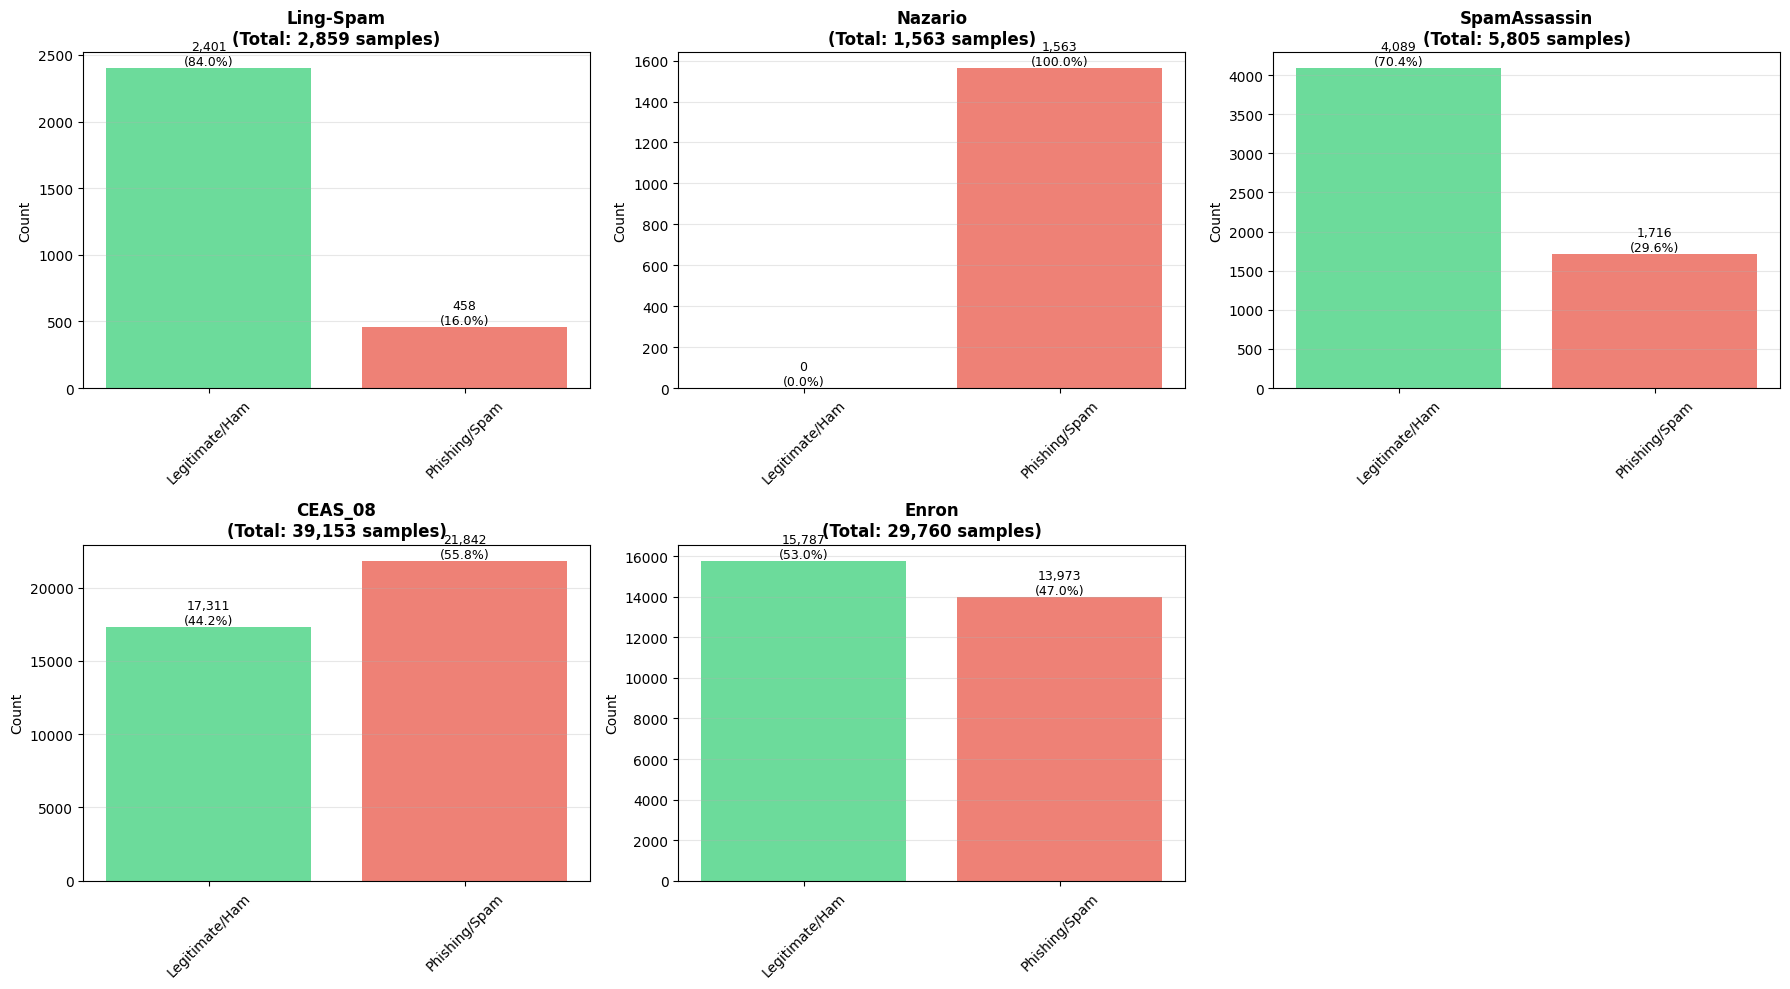


SUMMARY TABLE
                Total  Phishing/Spam  Legitimate/Ham  Phishing %  Legitimate %
Ling-Spam      2859.0          458.0          2401.0   16.019587     83.980413
Nazario        1563.0         1563.0             0.0  100.000000      0.000000
SpamAssassin   5805.0         1716.0          4089.0   29.560724     70.439276
CEAS_08       39153.0        21842.0         17311.0   55.786274     44.213726
Enron         29760.0        13973.0         15787.0   46.952285     53.047715



In [7]:
print("CLASS IMBALANCE ANALYSIS")
print("="*80)

class_distribution = {}

for name, df in standardized_datasets.items():
    print(f"\n{name}:")
    print(f"  Total samples: {len(df)}")

    label_counts = df['label'].value_counts().sort_index()
    label_percentages = df['label'].value_counts(normalize=True).sort_index() * 100

    class_distribution[name] = {
        'total': len(df),
        'phishing/spam': label_counts.get(1, 0),
        'legitimate/ham': label_counts.get(0, 0),
        'phishing_pct': label_percentages.get(1, 0),
        'legitimate_pct': label_percentages.get(0, 0)
    }

    print(f"  Phishing/Spam (1): {label_counts.get(1, 0)} ({label_percentages.get(1, 0):.2f}%)")
    print(f"  Legitimate/Ham (0): {label_counts.get(0, 0)} ({label_percentages.get(0, 0):.2f}%)")

    if len(label_counts) == 2:
        imbalance_ratio = max(label_counts) / min(label_counts)
        print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

num_datasets = len(standardized_datasets)
ncols = 3
nrows = (num_datasets + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(18, nrows * 5))
axes = axes.flatten()

for idx, (name, df) in enumerate(standardized_datasets.items()):
    ax = axes[idx]

    label_counts = df['label'].value_counts().sort_index()
    labels = ['Legitimate/Ham', 'Phishing/Spam']
    colors = ['#2ecc71', '#e74c3c']

    bars = ax.bar(labels, [label_counts.get(0, 0), label_counts.get(1, 0)], color=colors, alpha=0.7)
    ax.set_title(f'{name}\n(Total: {len(df):,} samples)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count', fontsize=10)
    ax.tick_params(axis='x', rotation=45)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}\n({height/len(df)*100:.1f}%)',
                ha='center', va='bottom', fontsize=9)

    ax.grid(axis='y', alpha=0.3)

for idx in range(num_datasets, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('class_distribution_by_dataset.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*80}")
print("SUMMARY TABLE")
print(f"{'='*80}")

import pandas as pd
summary_df = pd.DataFrame(class_distribution).T
summary_df = summary_df[['total', 'phishing/spam', 'legitimate/ham', 'phishing_pct', 'legitimate_pct']]
summary_df.columns = ['Total', 'Phishing/Spam', 'Legitimate/Ham', 'Phishing %', 'Legitimate %']
print(summary_df.to_string())
print(f"\n{'='*80}")

### Metadata Handling

METADATA ANALYSIS

Ling-Spam:
  Total records: 2859
  Columns: ['text', 'label', 'source_dataset', 'text_cleaned']

  No missing values found.

  Text Statistics:
    Mean length: 3252 characters
    Median length: 2056 characters
    Mean word count: 676 words
    Median word count: 406 words

  'Ling-Spam' added to 'source_dataset' column.

Nazario:
  Total records: 1563
  Columns: ['text', 'label', 'source_dataset', 'sender', 'receiver', 'date', 'urls', 'text_cleaned']

  Missing values:
    receiver: 95 (6.08%)
    date: 1 (0.06%)

  Text Statistics:
    Mean length: 1040 characters
    Median length: 675 characters
    Mean word count: 161 words
    Median word count: 107 words

  Date range:
    Earliest: 2015-10-30 00:00:48-05:00
    Latest: 2022-12-11 12:04:50+00:00
    Valid dates: 975 (62.38%)

  'Nazario' added to 'source_dataset' column.

SpamAssassin:
  Total records: 5805
  Columns: ['text', 'label', 'source_dataset', 'sender', 'receiver', 'date', 'urls', 'text_cleaned']


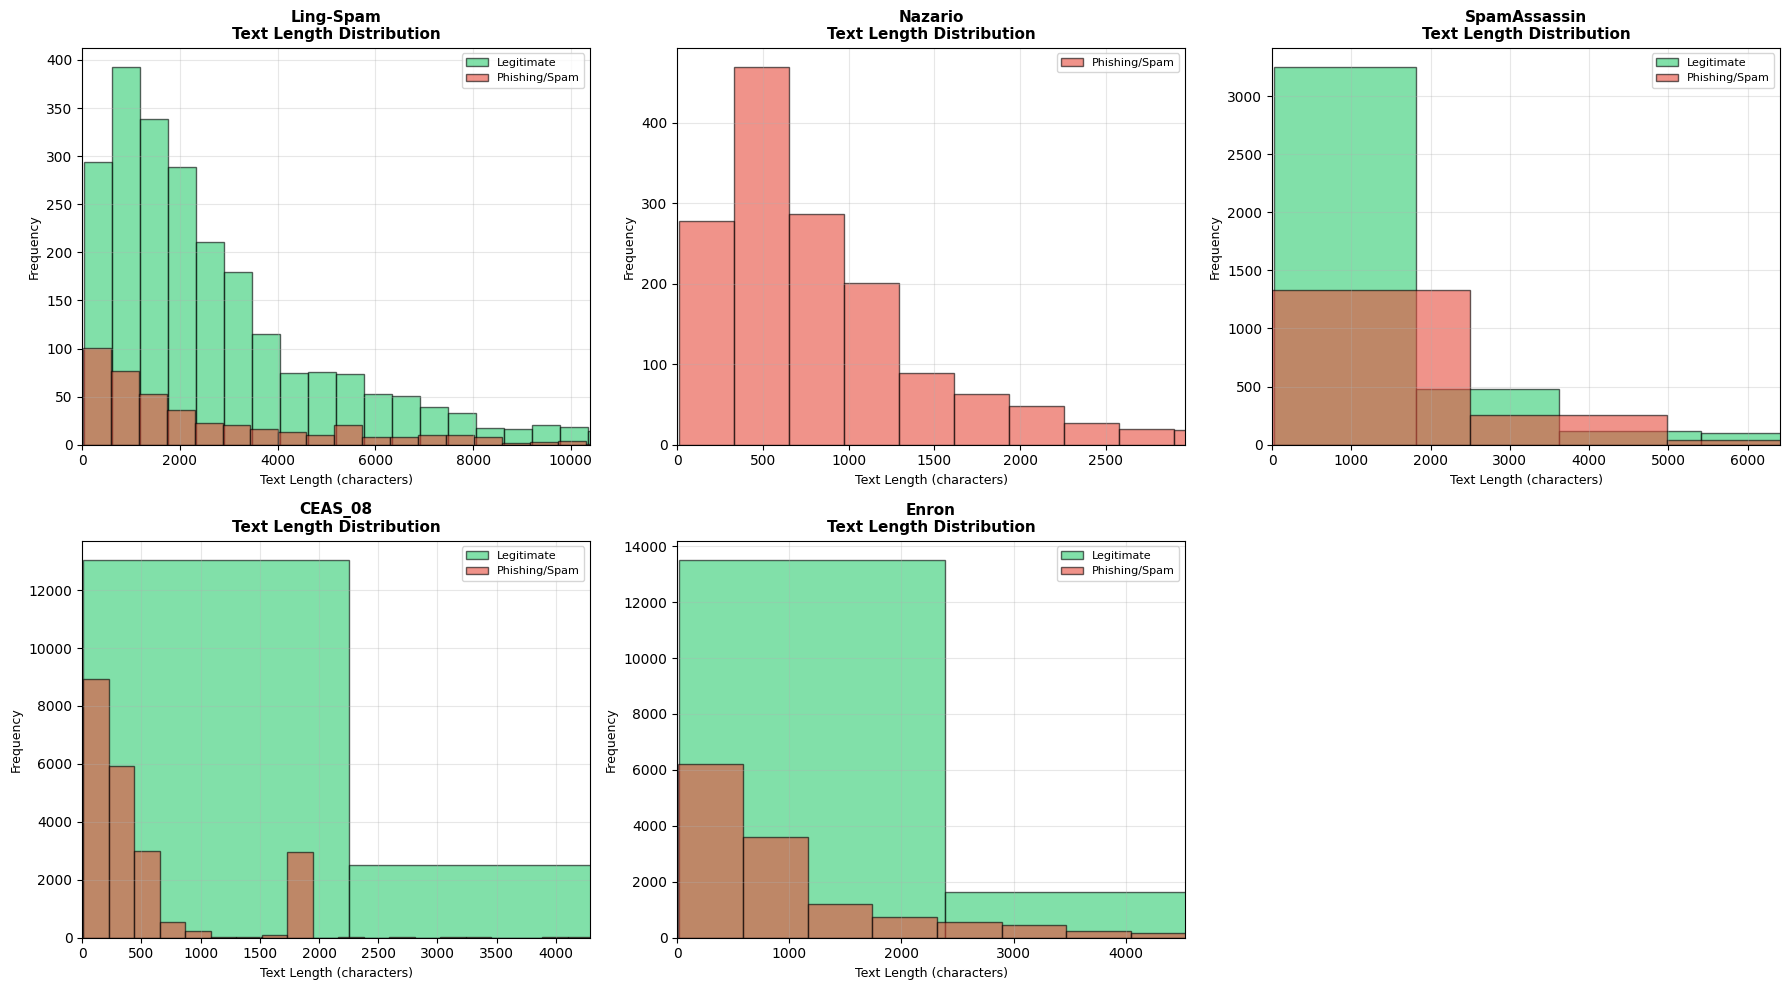

In [8]:
print("METADATA ANALYSIS")
print("="*80)

for name, df in standardized_datasets.items():
    print(f"\n{name}:")
    print(f"  Total records: {len(df)}")
    print(f"  Columns: {list(df.columns)}")

    # Check missing values in all columns
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n  Missing values:")
        for col, count in missing[missing > 0].items():
            print(f"    {col}: {count} ({count/len(df)*100:.2f}%)")
    else:
        print(f"\n  No missing values found.")

    # Analyze text length statistics
    df['text_length'] = df['text_cleaned'].str.len()
    df['word_count'] = df['text_cleaned'].str.split().str.len()

    print(f"\n  Text Statistics:")
    print(f"    Mean length: {df['text_length'].mean():.0f} characters")
    print(f"    Median length: {df['text_length'].median():.0f} characters")
    print(f"    Mean word count: {df['word_count'].mean():.0f} words")
    print(f"    Median word count: {df['word_count'].median():.0f} words")

    # Check for date column if exists
    if 'date' in df.columns:
        print(f"\n  Date range:")
        try:
            df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce')
            valid_dates = df['date_parsed'].dropna()
            if len(valid_dates) > 0:
                print(f"    Earliest: {valid_dates.min()}")
                print(f"    Latest: {valid_dates.max()}")
                print(f"    Valid dates: {len(valid_dates)} ({len(valid_dates)/len(df)*100:.2f}%)")
        except:
            print(f"    Unable to parse dates")

    print(f"\n  '{name}' added to 'source_dataset' column.")
    print(f"{'='*80}")

# Visualize text length distributions
num_datasets = len(standardized_datasets)
ncols = 3
nrows = (num_datasets + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(18, nrows * 5))
axes = axes.flatten()

for idx, (name, df) in enumerate(standardized_datasets.items()):
    ax = axes[idx]

    for label in [0, 1]:
        data = df[df['label'] == label]['text_length']
        if len(data) > 0:
            label_name = 'Legitimate' if label == 0 else 'Phishing/Spam'
            color = '#2ecc71' if label == 0 else '#e74c3c'
            ax.hist(data, bins=50, alpha=0.6, label=label_name, color=color, edgecolor='black')

    ax.set_title(f'{name}\nText Length Distribution', fontsize=11, fontweight='bold')
    ax.set_xlabel('Text Length (characters)', fontsize=9)
    ax.set_ylabel('Frequency', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    ax.set_xlim(0, df['text_length'].quantile(0.95))

for idx in range(num_datasets, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.savefig('text_length_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

### Sentiment Analysis (VADER)

SENTIMENT ANALYSIS (VADER)

Sentiment Statistics by Class:
--------------------------------------------------------------------------------

Legitimate (n=39,588):
  Compound: mean=0.490, std=0.600
  Negative: mean=0.037, std=0.046
  Positive: mean=0.092, std=0.064

Phishing/Spam (n=39,552):
  Compound: mean=0.471, std=0.608
  Negative: mean=0.051, std=0.065
  Positive: mean=0.145, std=0.100


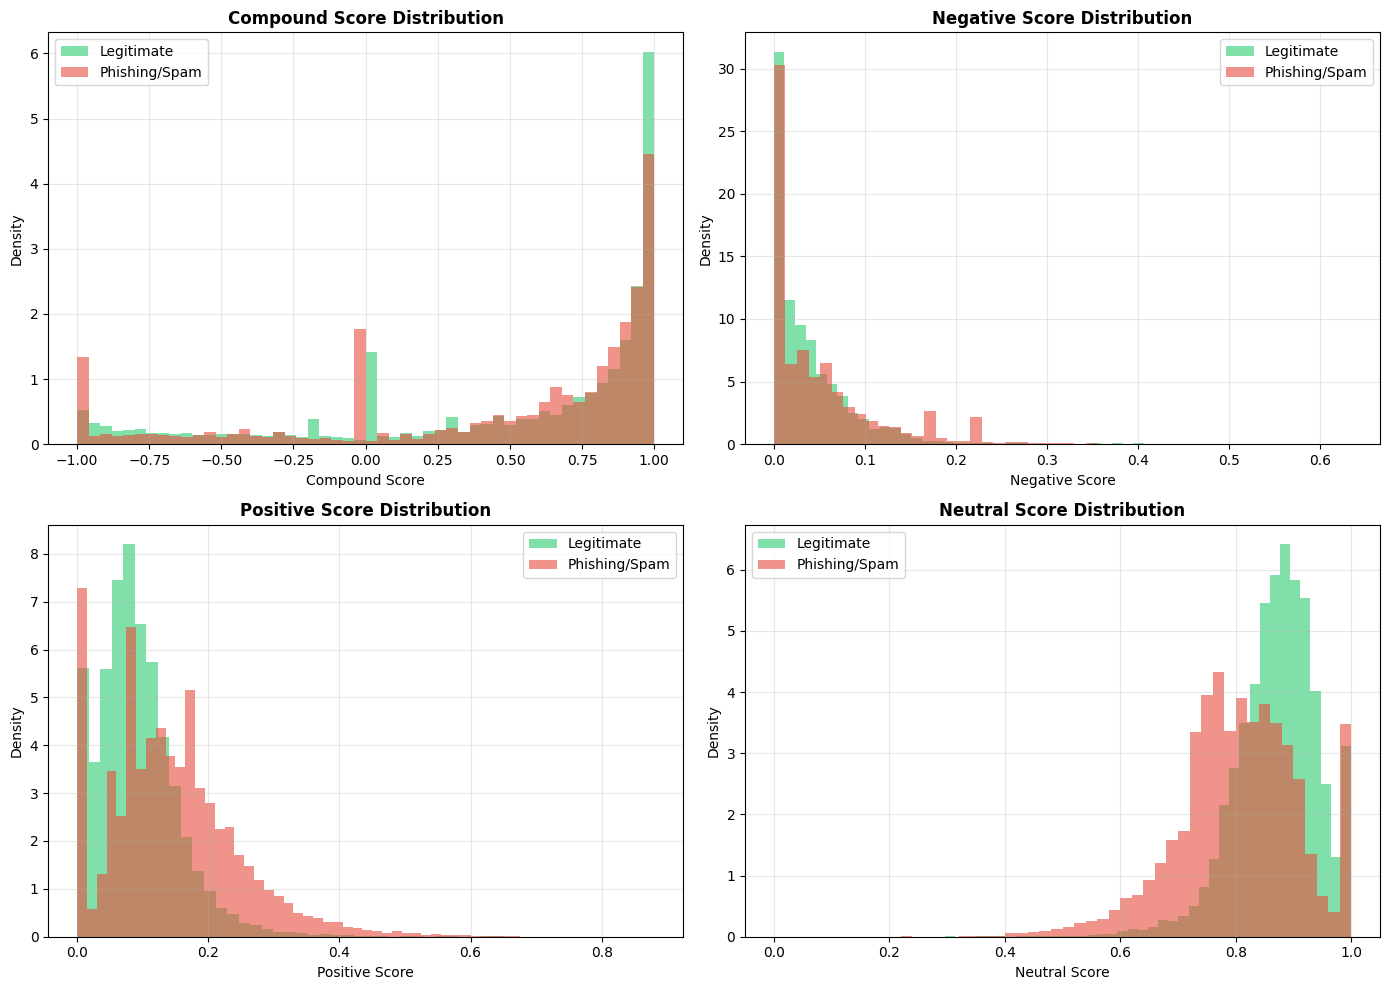

In [9]:
# VADER Sentiment Analysis
# Compute polarity scores for each email to detect fear/urgency cues in phishing

print("SENTIMENT ANALYSIS (VADER)")
print("="*80)

# Combine all standardized datasets for analysis
all_data = pd.concat(standardized_datasets.values(), ignore_index=True)

# Compute sentiment scores
def get_sentiment_scores(text):
    if not isinstance(text, str) or text.strip() == '':
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
    return sia.polarity_scores(text)

sentiment_scores = all_data['text_cleaned'].apply(get_sentiment_scores)
all_data['sentiment_neg'] = sentiment_scores.apply(lambda x: x['neg'])
all_data['sentiment_neu'] = sentiment_scores.apply(lambda x: x['neu'])
all_data['sentiment_pos'] = sentiment_scores.apply(lambda x: x['pos'])
all_data['sentiment_compound'] = sentiment_scores.apply(lambda x: x['compound'])

# Summary statistics by class
print("\nSentiment Statistics by Class:")
print("-"*80)
for label in [0, 1]:
    label_name = "Legitimate" if label == 0 else "Phishing/Spam"
    subset = all_data[all_data['label'] == label]
    print(f"\n{label_name} (n={len(subset):,}):")
    print(f"  Compound: mean={subset['sentiment_compound'].mean():.3f}, std={subset['sentiment_compound'].std():.3f}")
    print(f"  Negative: mean={subset['sentiment_neg'].mean():.3f}, std={subset['sentiment_neg'].std():.3f}")
    print(f"  Positive: mean={subset['sentiment_pos'].mean():.3f}, std={subset['sentiment_pos'].std():.3f}")

# Visualize sentiment distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sentiment_cols = ['sentiment_compound', 'sentiment_neg', 'sentiment_pos', 'sentiment_neu']
titles = ['Compound Score', 'Negative Score', 'Positive Score', 'Neutral Score']

for ax, col, title in zip(axes.flatten(), sentiment_cols, titles):
    for label in [0, 1]:
        subset = all_data[all_data['label'] == label][col]
        label_name = 'Legitimate' if label == 0 else 'Phishing/Spam'
        color = '#2ecc71' if label == 0 else '#e74c3c'
        ax.hist(subset, bins=50, alpha=0.6, label=label_name, color=color, density=True)
    ax.set_title(f'{title} Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel(title)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*80}")

### TF-IDF Word Importance

TF-IDF WORD IMPORTANCE ANALYSIS

Top 20 Tokens Indicative of PHISHING:
--------------------------------------------------
   1. http                      (coef: 5.5560)
   2. love                      (coef: 5.2285)
   3. account                   (coef: 4.9901)
   4. life                      (coef: 4.9784)
   5. click                     (coef: 4.4770)
   6. remove                    (coef: 4.4183)
   7. meds                      (coef: 4.2556)
   8. watches                   (coef: 3.9378)
   9. year year                 (coef: 3.7287)
  10. gr                        (coef: 3.6612)
  11. men                       (coef: 3.6273)
  12. viagra                    (coef: 3.6164)
  13. statements                (coef: 3.6127)
  14. investment                (coef: 3.4603)
  15. pills                     (coef: 3.4424)
  16. kindly                    (coef: 3.3799)
  17. guaranteed                (coef: 3.3710)
  18. site                      (coef: 3.2749)
  19. mortgage                  

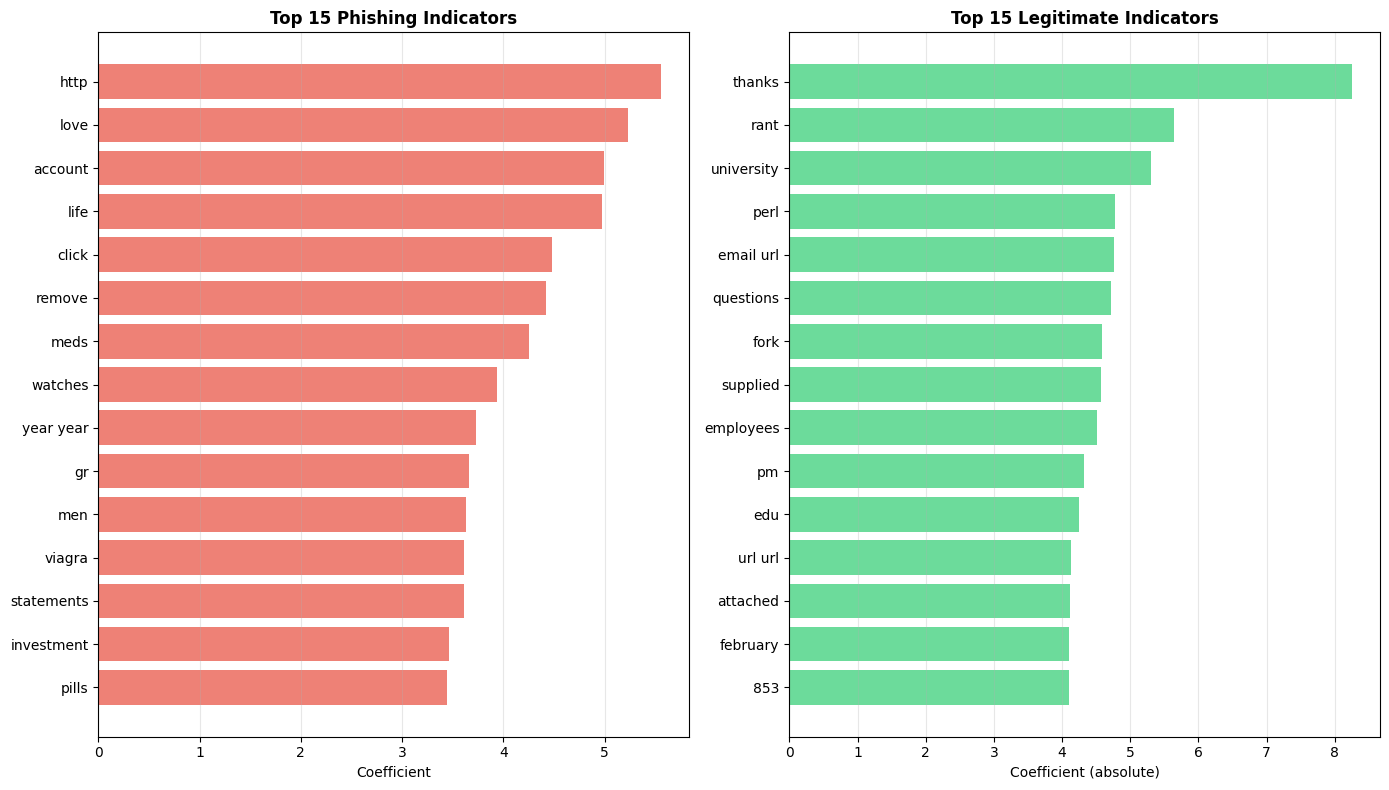

In [10]:
# TF-IDF Word Importance Analysis
# Identify most discriminative tokens between phishing and legitimate emails

print("TF-IDF WORD IMPORTANCE ANALYSIS")
print("="*80)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Vectorize text
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X_tfidf = tfidf.fit_transform(all_data['text_cleaned'].fillna(''))
y = all_data['label'].values

# Train logistic regression to get feature importance
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr.fit(X_tfidf, y)

# Get feature names and coefficients
feature_names = tfidf.get_feature_names_out()
coefficients = lr.coef_[0]

# Top tokens for phishing (positive coefficients)
phishing_indices = np.argsort(coefficients)[-20:][::-1]
print("\nTop 20 Tokens Indicative of PHISHING:")
print("-"*50)
for i, idx in enumerate(phishing_indices, 1):
    print(f"  {i:2d}. {feature_names[idx]:<25} (coef: {coefficients[idx]:.4f})")

# Top tokens for legitimate (negative coefficients)
legitimate_indices = np.argsort(coefficients)[:20]
print("\nTop 20 Tokens Indicative of LEGITIMATE:")
print("-"*50)
for i, idx in enumerate(legitimate_indices, 1):
    print(f"  {i:2d}. {feature_names[idx]:<25} (coef: {coefficients[idx]:.4f})")

# Visualize top features
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Phishing tokens
ax1 = axes[0]
top_phishing = [(feature_names[idx], coefficients[idx]) for idx in phishing_indices[:15]]
tokens, coefs = zip(*top_phishing)
ax1.barh(range(len(tokens)), coefs, color='#e74c3c', alpha=0.7)
ax1.set_yticks(range(len(tokens)))
ax1.set_yticklabels(tokens)
ax1.invert_yaxis()
ax1.set_xlabel('Coefficient')
ax1.set_title('Top 15 Phishing Indicators', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Legitimate tokens
ax2 = axes[1]
top_legitimate = [(feature_names[idx], abs(coefficients[idx])) for idx in legitimate_indices[:15]]
tokens, coefs = zip(*top_legitimate)
ax2.barh(range(len(tokens)), coefs, color='#2ecc71', alpha=0.7)
ax2.set_yticks(range(len(tokens)))
ax2.set_yticklabels(tokens)
ax2.invert_yaxis()
ax2.set_xlabel('Coefficient (absolute)')
ax2.set_title('Top 15 Legitimate Indicators', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('tfidf_word_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*80}")

### SHAP Analysis

SHAP ANALYSIS

Top 20 Features by Mean |SHAP| Value:
--------------------------------------------------
   1. url                       (SHAP: 0.1362)
   2. thanks                    (SHAP: 0.1140)
   3. love                      (SHAP: 0.0766)
   4. http                      (SHAP: 0.0736)
   5. watch                     (SHAP: 0.0732)
   6. python                    (SHAP: 0.0725)
   7. pm                        (SHAP: 0.0707)
   8. watches                   (SHAP: 0.0696)
   9. list                      (SHAP: 0.0692)
  10. click                     (SHAP: 0.0679)
  11. year                      (SHAP: 0.0678)
  12. 10                        (SHAP: 0.0675)
  13. language                  (SHAP: 0.0669)
  14. life                      (SHAP: 0.0659)
  15. date                      (SHAP: 0.0621)
  16. university                (SHAP: 0.0620)
  17. attached                  (SHAP: 0.0576)
  18. account                   (SHAP: 0.0527)
  19. edu                       (SHAP: 0.0520)
  2

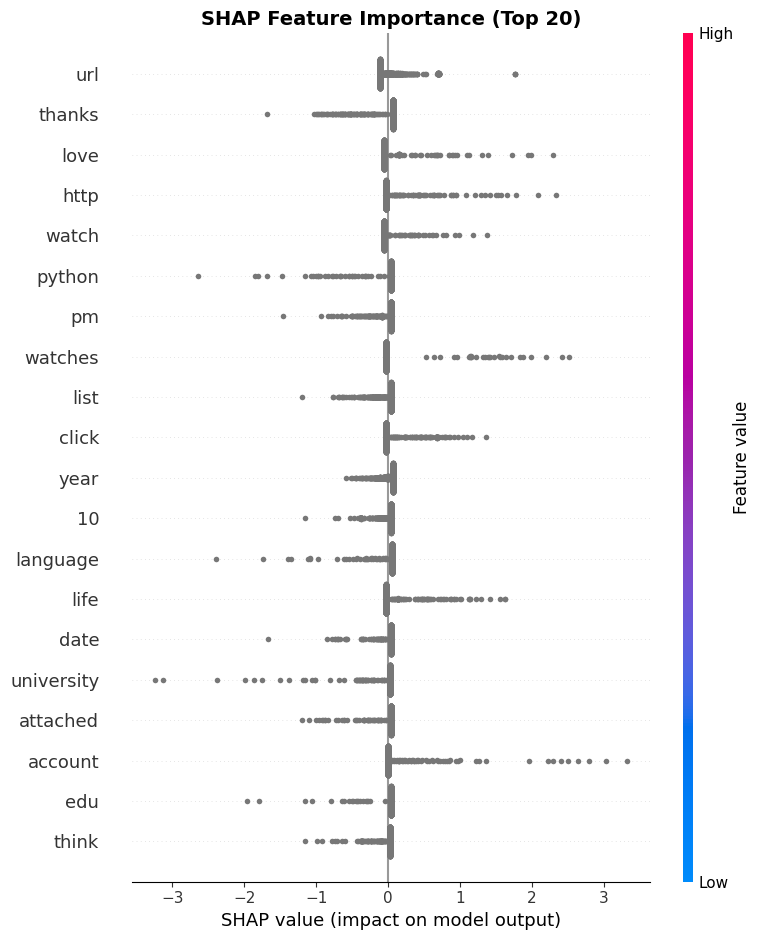

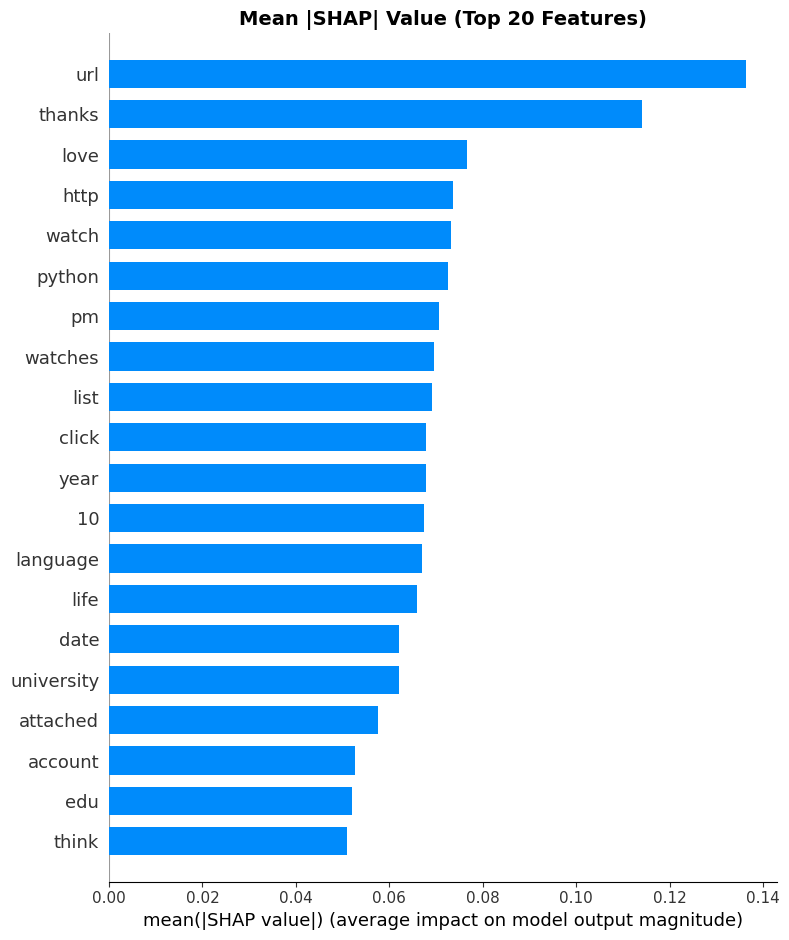

In [11]:
# SHAP Analysis for Token Contribution Explanations
# Quantify each token's contribution to classification

print("SHAP ANALYSIS")
print("="*80)

try:
    import shap
except ImportError:
    print("Installing shap...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'shap', '-q'])
    import shap

# Use a smaller sample for SHAP (computational efficiency)
sample_size = min(1000, len(all_data))
sample_indices = np.random.RandomState(42).choice(len(all_data), sample_size, replace=False)
X_sample = X_tfidf[sample_indices]

# Create SHAP explainer for logistic regression
explainer = shap.LinearExplainer(lr, X_sample, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_sample)

# Get mean absolute SHAP values for global importance
mean_shap = np.abs(shap_values).mean(axis=0)
top_shap_indices = np.argsort(mean_shap)[-20:][::-1]

print("\nTop 20 Features by Mean |SHAP| Value:")
print("-"*50)
for i, idx in enumerate(top_shap_indices, 1):
    print(f"  {i:2d}. {feature_names[idx]:<25} (SHAP: {mean_shap[idx]:.4f})")

# SHAP summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, max_display=20, show=False)
plt.title('SHAP Feature Importance (Top 20)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# SHAP bar plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", max_display=20, show=False)
plt.title('Mean |SHAP| Value (Top 20 Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('shap_bar.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*80}")

### K-means Clustering

K-MEANS CLUSTERING ANALYSIS

Finding optimal k...
  k=3: silhouette=0.0246
  k=4: silhouette=0.0333
  k=5: silhouette=0.0373
  k=6: silhouette=0.0377
  k=7: silhouette=0.0404
  k=8: silhouette=0.0417
  k=9: silhouette=0.0391
  k=10: silhouette=0.0437

Optimal k: 10 (silhouette=0.0437)

Cluster Composition:
--------------------------------------------------------------------------------
  Cluster 0: 39,747 samples (25,255 phishing, 14,492 legitimate)
  Cluster 1: 2,552 samples (2,540 phishing, 12 legitimate)
  Cluster 2: 5,429 samples (4,725 phishing, 704 legitimate)
  Cluster 3: 2,219 samples (2,219 phishing, 0 legitimate)
  Cluster 4: 12,155 samples (347 phishing, 11,808 legitimate)
  Cluster 5: 1,415 samples (1,406 phishing, 9 legitimate)
  Cluster 6: 10,034 samples (550 phishing, 9,484 legitimate)
  Cluster 7: 981 samples (981 phishing, 0 legitimate)
  Cluster 8: 1,019 samples (1,019 phishing, 0 legitimate)
  Cluster 9: 3,589 samples (510 phishing, 3,079 legitimate)

Top 10 Terms pe

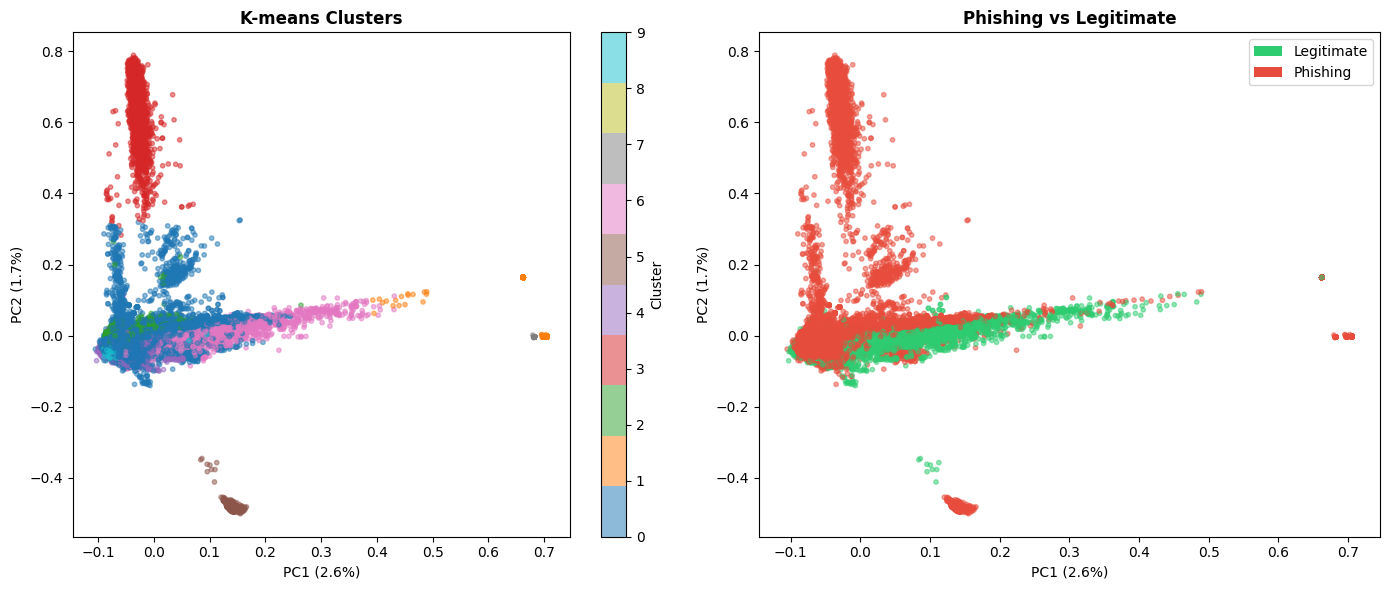

In [12]:
# K-means Clustering on TF-IDF Embeddings
# Find natural groupings in email corpus

print("K-MEANS CLUSTERING ANALYSIS")
print("="*80)

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Find optimal k using silhouette score
k_range = range(3, 11)
silhouette_scores = []

print("\nFinding optimal k...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_tfidf)
    score = silhouette_score(X_tfidf, labels, sample_size=5000)
    silhouette_scores.append(score)
    print(f"  k={k}: silhouette={score:.4f}")

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal k: {optimal_k} (silhouette={max(silhouette_scores):.4f})")

# Final clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
all_data['cluster'] = kmeans.fit_predict(X_tfidf)

# Cluster composition analysis
print(f"\nCluster Composition:")
print("-"*80)
for cluster in range(optimal_k):
    cluster_data = all_data[all_data['cluster'] == cluster]
    total = len(cluster_data)
    phishing = (cluster_data['label'] == 1).sum()
    legitimate = (cluster_data['label'] == 0).sum()
    print(f"  Cluster {cluster}: {total:,} samples ({phishing:,} phishing, {legitimate:,} legitimate)")

# Top terms per cluster
print(f"\nTop 10 Terms per Cluster:")
print("-"*80)
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for cluster in range(optimal_k):
    top_terms = [feature_names[i] for i in order_centroids[cluster, :10]]
    print(f"  Cluster {cluster}: {', '.join(top_terms)}")

# PCA visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot by cluster
ax1 = axes[0]
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=all_data['cluster'], cmap='tab10', alpha=0.5, s=10)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax1.set_title('K-means Clusters', fontsize=12, fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# Plot by label
ax2 = axes[1]
colors = ['#2ecc71' if l == 0 else '#e74c3c' for l in all_data['label']]
ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, alpha=0.5, s=10)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax2.set_title('Phishing vs Legitimate', fontsize=12, fontweight='bold')
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2ecc71', label='Legitimate'),
                   Patch(facecolor='#e74c3c', label='Phishing')]
ax2.legend(handles=legend_elements)

plt.tight_layout()
plt.savefig('kmeans_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*80}")

### Word Clouds

WORD CLOUD VISUALIZATION


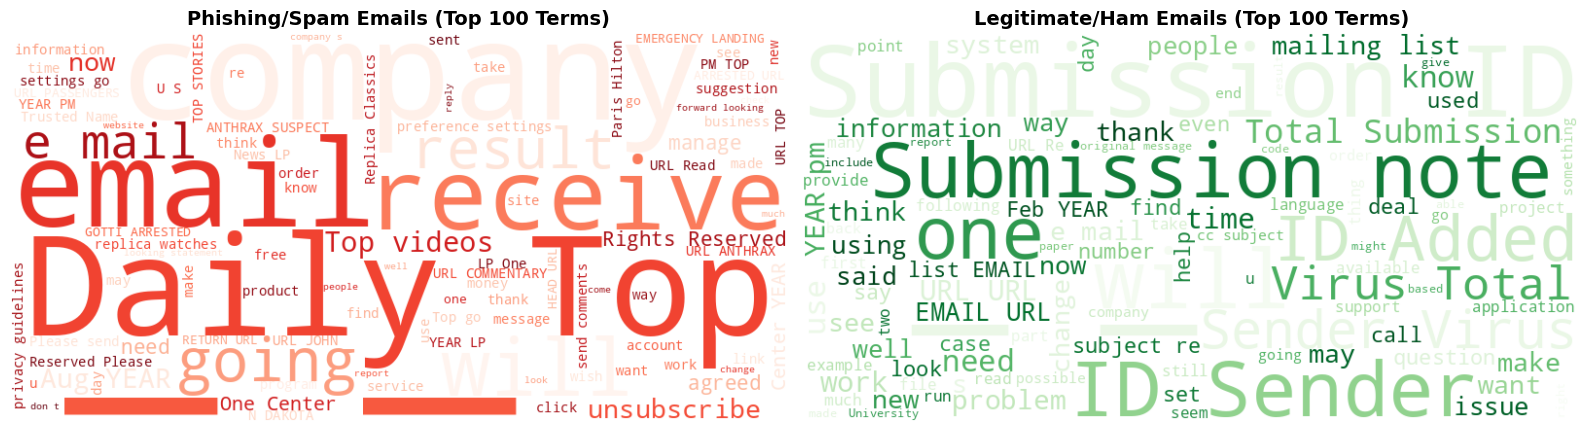

In [13]:
# Word Clouds for Phishing vs Legitimate
# Visualize most frequent terms (top 100)

print("WORD CLOUD VISUALIZATION")
print("="*80)

try:
    from wordcloud import WordCloud
except ImportError:
    print("Installing wordcloud...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'wordcloud', '-q'])
    from wordcloud import WordCloud

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Phishing word cloud
phishing_text = ' '.join(all_data[all_data['label'] == 1]['text_cleaned'].fillna(''))
wc_phishing = WordCloud(width=800, height=400, max_words=100, background_color='white',
                        colormap='Reds', random_state=42).generate(phishing_text)
axes[0].imshow(wc_phishing, interpolation='bilinear')
axes[0].set_title('Phishing/Spam Emails (Top 100 Terms)', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Legitimate word cloud
legitimate_text = ' '.join(all_data[all_data['label'] == 0]['text_cleaned'].fillna(''))
wc_legitimate = WordCloud(width=800, height=400, max_words=100, background_color='white',
                          colormap='Greens', random_state=42).generate(legitimate_text)
axes[1].imshow(wc_legitimate, interpolation='bilinear')
axes[1].set_title('Legitimate/Ham Emails (Top 100 Terms)', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.savefig('word_clouds.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*80}")

### Document Length CDF

DOCUMENT LENGTH CDF ANALYSIS

Token Count Percentiles:
--------------------------------------------------
  50th percentile: 125 tokens
  75th percentile: 289 tokens
  90th percentile: 564 tokens
  95th percentile: 854 tokens
  99th percentile: 2131 tokens

Coverage at 512 tokens: 88.49%


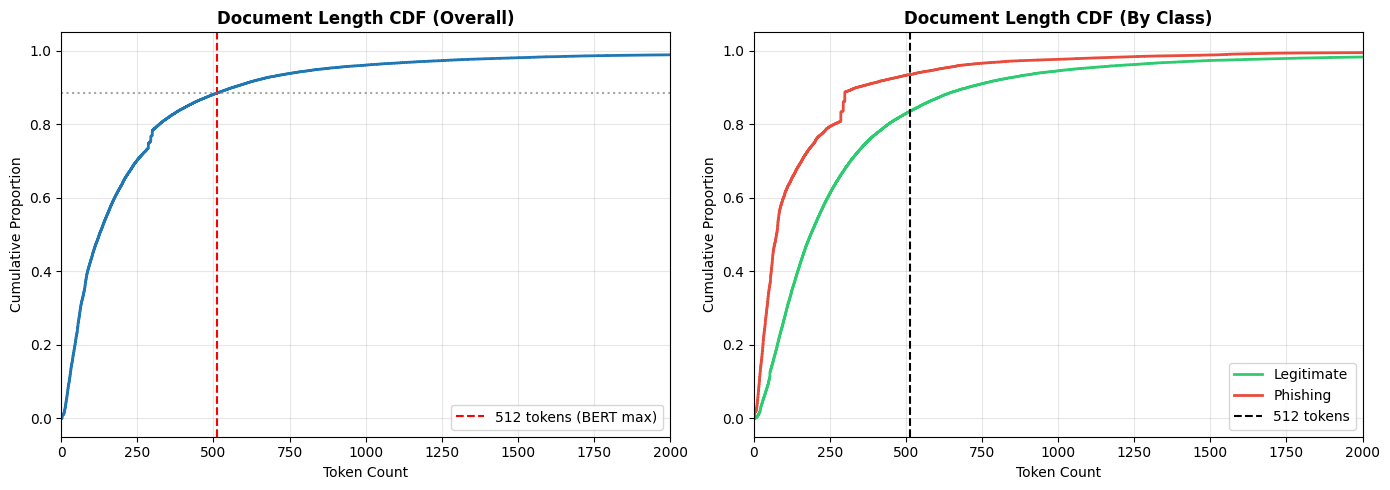

In [14]:
# Document Length CDF for Truncation Threshold Analysis
# Determine optimal truncation length for BERT (512 tokens max)

print("DOCUMENT LENGTH CDF ANALYSIS")
print("="*80)

# Approximate token count (words as proxy for WordPiece tokens)
all_data['approx_tokens'] = all_data['text_cleaned'].str.split().str.len()

# Calculate percentiles
percentiles = [50, 75, 90, 95, 99]
print("\nToken Count Percentiles:")
print("-"*50)
for p in percentiles:
    val = all_data['approx_tokens'].quantile(p/100)
    print(f"  {p}th percentile: {val:.0f} tokens")

# Coverage at 512 tokens
coverage_512 = (all_data['approx_tokens'] <= 512).mean() * 100
print(f"\nCoverage at 512 tokens: {coverage_512:.2f}%")

# CDF plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall CDF
ax1 = axes[0]
sorted_tokens = np.sort(all_data['approx_tokens'])
cdf = np.arange(1, len(sorted_tokens) + 1) / len(sorted_tokens)
ax1.plot(sorted_tokens, cdf, linewidth=2)
ax1.axvline(x=512, color='red', linestyle='--', label='512 tokens (BERT max)')
ax1.axhline(y=coverage_512/100, color='gray', linestyle=':', alpha=0.7)
ax1.set_xlabel('Token Count')
ax1.set_ylabel('Cumulative Proportion')
ax1.set_title('Document Length CDF (Overall)', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 2000)
ax1.legend()
ax1.grid(alpha=0.3)

# CDF by class
ax2 = axes[1]
for label in [0, 1]:
    subset = all_data[all_data['label'] == label]['approx_tokens']
    sorted_vals = np.sort(subset)
    cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
    label_name = 'Legitimate' if label == 0 else 'Phishing'
    color = '#2ecc71' if label == 0 else '#e74c3c'
    ax2.plot(sorted_vals, cdf, label=label_name, color=color, linewidth=2)

ax2.axvline(x=512, color='black', linestyle='--', label='512 tokens')
ax2.set_xlabel('Token Count')
ax2.set_ylabel('Cumulative Proportion')
ax2.set_title('Document Length CDF (By Class)', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 2000)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('document_length_cdf.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n{'='*80}")

### Source-labeled PCA

SOURCE-LABELED PCA VISUALIZATION


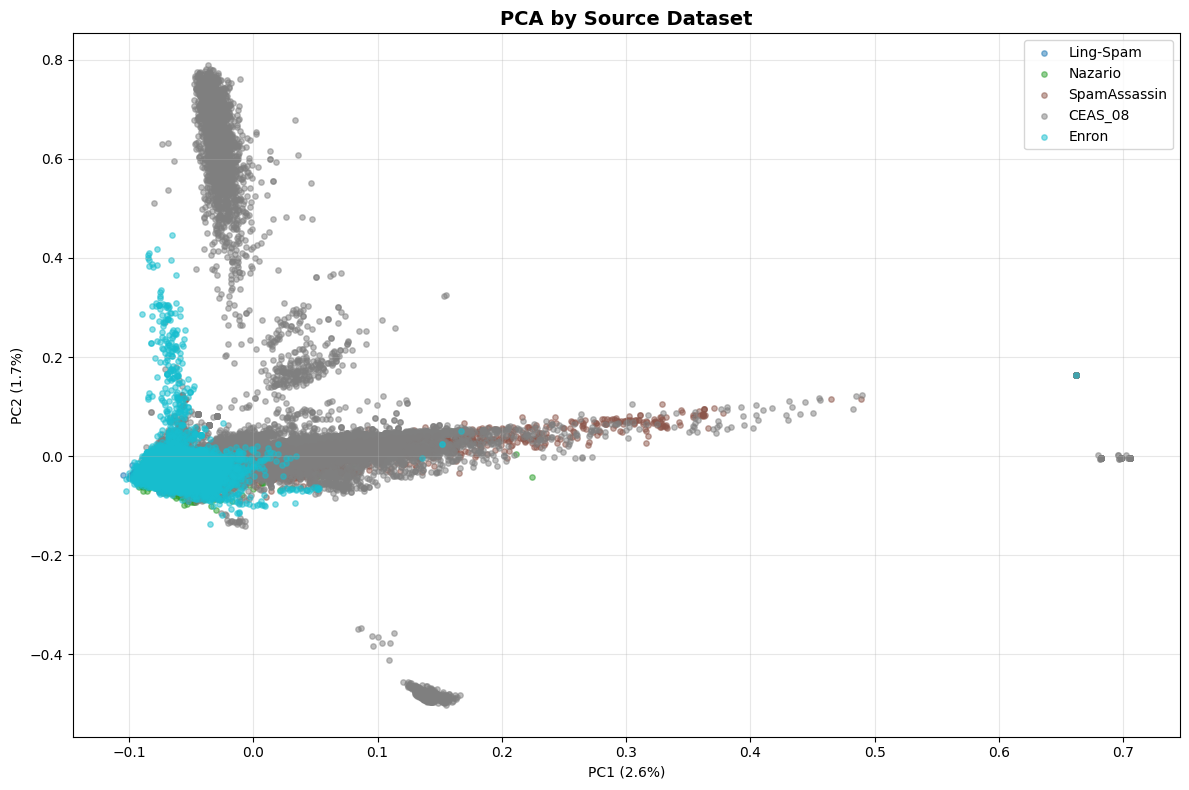


Source Dataset Statistics:
--------------------------------------------------
  Ling-Spam: 2,859 samples, 16.0% phishing
  Nazario: 1,563 samples, 100.0% phishing
  SpamAssassin: 5,805 samples, 29.6% phishing
  CEAS_08: 39,153 samples, 55.8% phishing
  Enron: 29,760 samples, 47.0% phishing



In [15]:
# Source-labeled PCA Visualization
# Visualize feature overlap between different source datasets

print("SOURCE-LABELED PCA VISUALIZATION")
print("="*80)

# PCA already computed above (X_pca)
all_data['pca_1'] = X_pca[:, 0]
all_data['pca_2'] = X_pca[:, 1]

sources = all_data['source_dataset'].unique()
n_sources = len(sources)

fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, n_sources))

for i, source in enumerate(sources):
    subset = all_data[all_data['source_dataset'] == source]
    ax.scatter(subset['pca_1'], subset['pca_2'], c=[colors[i]], label=source, alpha=0.5, s=15)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA by Source Dataset', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('pca_by_source.png', dpi=300, bbox_inches='tight')
plt.show()

# Source overlap statistics
print("\nSource Dataset Statistics:")
print("-"*50)
for source in sources:
    subset = all_data[all_data['source_dataset'] == source]
    phishing_pct = (subset['label'] == 1).mean() * 100
    print(f"  {source}: {len(subset):,} samples, {phishing_pct:.1f}% phishing")

print(f"\n{'='*80}")

#### Deduplication


In [16]:
# Deduplication and Overlap Detection

def hash_text(text):
    return hashlib.md5(text.encode('utf-8')).hexdigest()

for name, df in standardized_datasets.items():
    df['text_hash'] = df['text_cleaned'].apply(hash_text)

# Check for duplicates within each dataset
print("\n1. WITHIN-DATASET DUPLICATES")
print("-"*80)

within_dataset_stats = {}

for name, df in standardized_datasets.items():
    duplicates = df.duplicated(subset=['text_hash'], keep='first')
    num_duplicates = duplicates.sum()
    duplicate_pct = (num_duplicates / len(df)) * 100

    within_dataset_stats[name] = {
        'total': len(df),
        'duplicates': num_duplicates,
        'duplicate_pct': duplicate_pct,
        'unique': len(df) - num_duplicates
    }

    print(f"\n{name}:")
    print(f"  Total records: {len(df)}")
    print(f"  Duplicates found: {num_duplicates} ({duplicate_pct:.2f}%)")
    print(f"  Unique records: {len(df) - num_duplicates}")

    # Remove duplicates
    standardized_datasets[name] = df[~duplicates].copy()
    print(f"  Records after deduplication: {len(standardized_datasets[name])}")

# Create a combined dataset temporarily to check cross-dataset duplicates
all_hashes = []
dataset_names = []

for name, df in standardized_datasets.items():
    all_hashes.extend(df['text_hash'].tolist())
    dataset_names.extend([name] * len(df))

hash_df = pd.DataFrame({
    'hash': all_hashes,
    'dataset': dataset_names
})

# Find hashes that appear in multiple datasets
hash_counts = hash_df.groupby('hash')['dataset'].apply(list).reset_index()
hash_counts['num_datasets'] = hash_counts['dataset'].apply(len)
cross_dataset_duplicates = hash_counts[hash_counts['num_datasets'] > 1]

print(f"\nTotal unique messages across all datasets: {len(hash_counts)}")
print(f"Messages appearing in multiple datasets: {len(cross_dataset_duplicates)}")

if len(cross_dataset_duplicates) > 0:
    print(f"\nBreakdown of cross-dataset duplicates:")
    for idx, row in cross_dataset_duplicates.head(10).iterrows():
        datasets_involved = ', '.join(set(row['dataset']))
        print(f"  - Message appears in: {datasets_involved} ({row['num_datasets']} times)")

    # Track which hashes to keep (first occurrence only)
    seen_hashes = set()

    for name, df in standardized_datasets.items():
        df['cross_dataset_duplicate'] = df['text_hash'].apply(lambda h: h in seen_hashes)

        seen_hashes.update(df['text_hash'].tolist())

        before_count = len(df)
        df = df[~df['cross_dataset_duplicate']].copy()
        after_count = len(df)
        removed = before_count - after_count

        standardized_datasets[name] = df.drop(columns=['cross_dataset_duplicate'])

        if removed > 0:
            print(f"  {name}: Removed {removed} cross-dataset duplicates")
else:
    print("No cross-dataset duplicates found!")

final_stats = []
for name, df in standardized_datasets.items():
    final_stats.append({
        'Dataset': name,
        'Final Count': len(df),
        'Phishing/Spam': (df['label'] == 1).sum(),
        'Legitimate/Ham': (df['label'] == 0).sum()
    })

final_df = pd.DataFrame(final_stats)
print(f"\n{final_df.to_string(index=False)}")

total_samples = final_df['Final Count'].sum()
total_phishing = final_df['Phishing/Spam'].sum()
total_legitimate = final_df['Legitimate/Ham'].sum()

print(f"\nOverall Totals:")
print(f"  Total samples: {total_samples:,}")
print(f"  Phishing/Spam: {total_phishing:,} ({total_phishing/total_samples*100:.2f}%)")
print(f"  Legitimate/Ham: {total_legitimate:,} ({total_legitimate/total_samples*100:.2f}%)")
print(f"  Imbalance ratio: {max(total_phishing, total_legitimate) / min(total_phishing, total_legitimate):.2f}:1")

print(f"\n{'='*80}")


1. WITHIN-DATASET DUPLICATES
--------------------------------------------------------------------------------

Ling-Spam:
  Total records: 2859
  Duplicates found: 0 (0.00%)
  Unique records: 2859
  Records after deduplication: 2859

Nazario:
  Total records: 1563
  Duplicates found: 22 (1.41%)
  Unique records: 1541
  Records after deduplication: 1541

SpamAssassin:
  Total records: 5805
  Duplicates found: 25 (0.43%)
  Unique records: 5780
  Records after deduplication: 5780

CEAS_08:
  Total records: 39153
  Duplicates found: 4788 (12.23%)
  Unique records: 34365
  Records after deduplication: 34365

Enron:
  Total records: 29760
  Duplicates found: 344 (1.16%)
  Unique records: 29416
  Records after deduplication: 29416

Total unique messages across all datasets: 73961
Messages appearing in multiple datasets: 0
No cross-dataset duplicates found!

     Dataset  Final Count  Phishing/Spam  Legitimate/Ham
   Ling-Spam         2859            458            2401
     Nazario         1

# Merging Datasets

MERGING DATASETS
All columns found: ['date', 'date_parsed', 'label', 'receiver', 'sender', 'source_dataset', 'text', 'text_cleaned', 'text_hash', 'text_length', 'urls', 'word_count']
  Ling-Spam: 2,401 benign, 458 malicious
  Nazario: 0 benign, 1,541 malicious
  SpamAssassin: 4,087 benign, 1,693 malicious
  CEAS_08: 17,233 benign, 17,132 malicious
  Enron: 15,470 benign, 13,946 malicious

MERGED DATASET SUMMARY

merged_data:
   - Total records: 73,961
   - Benign (label=0): 39,191 (52.99%)
   - Malicious (label=1): 34,770 (47.01%)
   - Columns: ['text', 'label', 'source_dataset', 'text_cleaned', 'text_length', 'word_count', 'text_hash', 'sender', 'receiver', 'date', 'urls', 'subject', 'body', 'date_parsed']

Source dataset distribution:
   CEAS_08: 34,365 (46.46%)
   Enron: 29,416 (39.77%)
   SpamAssassin: 5,780 (7.81%)
   Ling-Spam: 2,859 (3.87%)
   Nazario: 1,541 (2.08%)

Missing values:
   sender: 32,275 (43.64%)
   receiver: 33,033 (44.66%)
   date: 32,276 (43.64%)
   urls: 32,275 

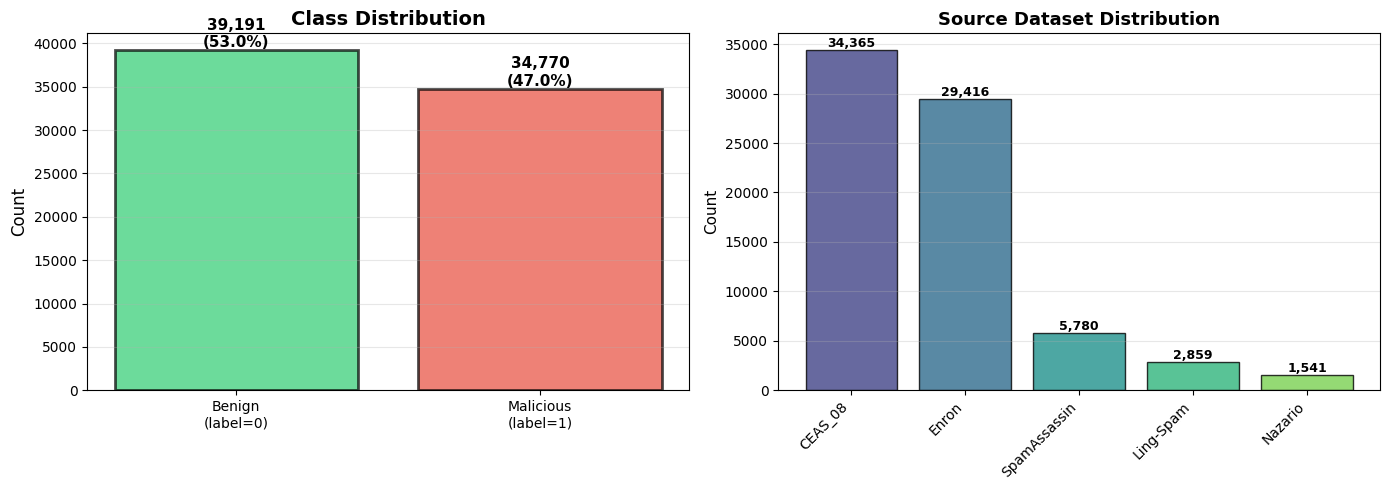


SAVING DATASETS

Malicious dataset (for annotation):
   File: malicious_phishing_corpus.csv
   Saved 34,770 records
   Annotation columns added: 'annotation_label', 'annotator_confidence'

Benign dataset:
   File: benign_corpus.csv
   Saved 39,191 records

Combined dataset (reference):
   File: merged_phishing_corpus.csv
   Saved 73,961 records

DATASET EXPORT COMPLETE


In [19]:
# Merging All Datasets into a Single Combined DataFrame

print("MERGING DATASETS")
print("="*80)

all_columns = set()
for df in standardized_datasets.values():
    all_columns.update(df.columns)

print(f"All columns found: {sorted(all_columns)}")

required_columns = ['text_cleaned', 'label', 'source_dataset', 'text_length', 'word_count', 'text_hash']
optional_columns = ['sender', 'receiver', 'date', 'urls', 'subject', 'body']

all_datasets = []

for name, df in standardized_datasets.items():
    df_merge = df.copy()

    # Ensure all required columns exist
    for col in required_columns:
        if col not in df_merge.columns:
            if col == 'text_hash':
                df_merge[col] = df_merge['text_cleaned'].apply(hash_text)
            elif col == 'text_length':
                df_merge[col] = df_merge['text_cleaned'].str.len()
            elif col == 'word_count':
                df_merge[col] = df_merge['text_cleaned'].str.split().str.len()
            else:
                df_merge[col] = None

    # Add optional columns if they don't exist
    for col in optional_columns:
        if col not in df_merge.columns:
            df_merge[col] = None

    benign_count = (df_merge['label'] == 0).sum()
    malicious_count = (df_merge['label'] == 1).sum()
    print(f"  {name}: {benign_count:,} benign, {malicious_count:,} malicious")

    all_datasets.append(df_merge)

# Merge all datasets
merged_data = pd.concat(all_datasets, axis=0, ignore_index=True)

# Split into malicious and benign datasets
malicious_data = merged_data[merged_data['label'] == 1].reset_index(drop=True)
benign_data = merged_data[merged_data['label'] == 0].reset_index(drop=True)

print(f"\n{'='*80}")
print("MERGED DATASET SUMMARY")
print(f"{'='*80}")

total_benign = len(benign_data)
total_malicious = len(malicious_data)

print(f"\nmerged_data:")
print(f"   - Total records: {len(merged_data):,}")
print(f"   - Benign (label=0): {total_benign:,} ({total_benign/len(merged_data)*100:.2f}%)")
print(f"   - Malicious (label=1): {total_malicious:,} ({total_malicious/len(merged_data)*100:.2f}%)")
print(f"   - Columns: {list(merged_data.columns)}")

print(f"\nSource dataset distribution:")
source_counts = merged_data['source_dataset'].value_counts()
for source, count in source_counts.items():
    print(f"   {source}: {count:,} ({count/len(merged_data)*100:.2f}%)")

print(f"\nMissing values:")
missing = merged_data.isnull().sum()
missing_cols = missing[missing > 0]
if len(missing_cols) > 0:
    for col, count in missing_cols.items():
        print(f"   {col}: {count:,} ({count/len(merged_data)*100:.2f}%)")
else:
    print(f"   No missing values in required columns.")

# Visualize the merged dataset
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Class distribution
ax1 = axes[0]
counts = [total_benign, total_malicious]
labels = ['Benign\n(label=0)', 'Malicious\n(label=1)']
colors = ['#2ecc71', '#e74c3c']
bars = ax1.bar(labels, counts, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{count:,}\n({count/len(merged_data)*100:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Source dataset distribution
ax2 = axes[1]
colors_source = plt.cm.viridis(np.linspace(0.2, 0.8, len(source_counts)))
bars2 = ax2.bar(range(len(source_counts)), source_counts.values, color=colors_source, alpha=0.8, edgecolor='black')
ax2.set_xticks(range(len(source_counts)))
ax2.set_xticklabels(source_counts.index, rotation=45, ha='right', fontsize=10)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('Source Dataset Distribution', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar, count in zip(bars2, source_counts.values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('merged_dataset_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the datasets
print(f"\n{'='*80}")
print("SAVING DATASETS")
print(f"{'='*80}")

# Select columns to save
save_cols = ['text_cleaned', 'label', 'source_dataset', 'text_length', 'word_count']

# Add optional columns that have data
for col in optional_columns:
    if col in merged_data.columns and merged_data[col].notna().sum() > 0:
        save_cols.append(col)

# Save malicious dataset (for annotation)
# Include annotation columns for human annotators
malicious_export = malicious_data[save_cols].copy()

malicious_export['annotation_label'] = ''
malicious_export['annotator_confidence'] = ''

malicious_filename = 'malicious_phishing_corpus.csv'
malicious_export.to_csv(malicious_filename, index=False, encoding='utf-8')
print(f"\nMalicious dataset (for annotation):")
print(f"   File: {malicious_filename}")
print(f"   Saved {len(malicious_export):,} records")
print(f"   Annotation columns added: 'annotation_label', 'annotator_confidence'")

# Save benign dataset
benign_filename = 'benign_corpus.csv'
benign_data[save_cols].to_csv(benign_filename, index=False, encoding='utf-8')
print(f"\nBenign dataset:")
print(f"   File: {benign_filename}")
print(f"   Saved {len(benign_data):,} records")

# Save combined dataset (for reference)
combined_filename = 'merged_phishing_corpus.csv'
merged_data[save_cols].to_csv(combined_filename, index=False, encoding='utf-8')
print(f"\nCombined dataset (reference):")
print(f"   File: {combined_filename}")
print(f"   Saved {len(merged_data):,} records")

print(f"\n{'='*80}")
print("DATASET EXPORT COMPLETE")
print(f"{'='*80}")

In [20]:
import pandas as pd

# Load the malicious phishing corpus
malicious_filename = 'malicious_phishing_corpus.csv'
malicious_df = pd.read_csv(malicious_filename)

print(f"Original shape: {malicious_df.shape}")
print("First 5 rows of original data (showing source_dataset):")
display(malicious_df[['source_dataset', 'text_cleaned']].head())

# Randomize the rows
malicious_df_randomized = malicious_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the randomized DataFrame back to the CSV
malicious_df_randomized.to_csv(malicious_filename, index=False, encoding='utf-8')

print(f"\nRandomized data saved to {malicious_filename}")
print(f"New shape: {malicious_df_randomized.shape}")
print("First 5 rows of randomized data (showing source_dataset):")
display(malicious_df_randomized[['source_dataset', 'text_cleaned']].head())

print("To confirm randomization, you can inspect the 'source_dataset' column in the displayed head samples.")

Original shape: (34770, 11)
First 5 rows of original data (showing source_dataset):


,source_dataset,text_cleaned
0,Ling-Spam,"~[b,jhy+"
1,Ling-Spam,the internet success toolbox note : we do not ...
2,Ling-Spam,free stealth 3 . 0 bulk email software . . . j...
3,Ling-Spam,"need more money ? hi , would you like to earn ..."
4,Ling-Spam,cable decsrambler now only $ 6 . 99 ! this is ...



Randomized data saved to malicious_phishing_corpus.csv
New shape: (34770, 11)
First 5 rows of randomized data (showing source_dataset):


,source_dataset,text_cleaned
0,Enron,hello : hello : silagra is the generic version...
1,Enron,promotion plan to cvs @ bruce - guenter . dynd...
2,CEAS_08,Ranking And Reviews Of The Top 5 Penis Enlarge...
3,CEAS_08,Get the Finest Rolex Watch Replica ! Classical...
4,CEAS_08,Get armed for a new love battle Get ready for ...


To confirm randomization, you can inspect the 'source_dataset' column in the displayed head samples.


## Dataset Statistics Summary

In [21]:
# Dataset Statistics for Research Tracking
# Update these values as annotation progresses

print("DATASET STATISTICS")
print("="*80)

# Total merged (from this EDA)
total_merged = len(merged_data)
total_phishing_merged = len(malicious_data)
total_benign_merged = len(benign_data)

print(f"\n1. MERGED DATASET (from EDA)")
print(f"   Total: {total_merged:,}")
print(f"   Phishing: {total_phishing_merged:,}")
print(f"   Benign: {total_benign_merged:,}")

# Source breakdown
print(f"\n   Per source:")
for source in merged_data['source_dataset'].unique():
    subset = merged_data[merged_data['source_dataset'] == source]
    phishing_count = (subset['label'] == 1).sum()
    benign_count = (subset['label'] == 0).sum()
    print(f"   - {source}: {len(subset):,} total ({phishing_count:,} phishing, {benign_count:,} benign)")

# Placeholder for annotation tracking
# Update these after annotation
total_annotated = 0  # Update after annotation
annotated_by_class = {
    1: 0,  # Commercial/R-18
    2: 0,  # Monetary
    3: 0,  # Credential
    4: 0,  # Generic/Deceptive
}

print(f"\n2. ANNOTATED (update manually after annotation)")
print(f"   Total annotated: {total_annotated:,}")
print(f"   Class 1 (Commercial/R-18): {annotated_by_class[1]:,}")
print(f"   Class 2 (Monetary): {annotated_by_class[2]:,}")
print(f"   Class 3 (Credential): {annotated_by_class[3]:,}")
print(f"   Class 4 (Generic/Deceptive): {annotated_by_class[4]:,}")

# Placeholder for training data
# Update these after final dataset preparation
total_training = 0  # Update after train/val/test split
train_count = 0
val_count = 0
test_count = 0

print(f"\n3. TRAINING DATA (update after final preparation)")
print(f"   Total used for training: {total_training:,}")
print(f"   Train set: {train_count:,}")
print(f"   Validation set: {val_count:,}")
print(f"   Test set: {test_count:,}")

print(f"\n{'='*80}")

DATASET STATISTICS

1. MERGED DATASET (from EDA)
   Total: 73,961
   Phishing: 34,770
   Benign: 39,191

   Per source:
   - Ling-Spam: 2,859 total (458 phishing, 2,401 benign)
   - Nazario: 1,541 total (1,541 phishing, 0 benign)
   - SpamAssassin: 5,780 total (1,693 phishing, 4,087 benign)
   - CEAS_08: 34,365 total (17,132 phishing, 17,233 benign)
   - Enron: 29,416 total (13,946 phishing, 15,470 benign)

2. ANNOTATED (update manually after annotation)
   Total annotated: 0
   Class 1 (Commercial/R-18): 0
   Class 2 (Monetary): 0
   Class 3 (Credential): 0
   Class 4 (Generic/Deceptive): 0

3. TRAINING DATA (update after final preparation)
   Total used for training: 0
   Train set: 0
   Validation set: 0
   Test set: 0

